# Homework 4 - Applied Machine Learning
#### Basil Vetas (bsv2111)&nbsp;&nbsp;&nbsp;—&nbsp;&nbsp;&nbsp;Date: April 15th, 2019

In this homework, we try to solve the problem of moderating the science subreddit r/science. You can find the data [here](https://www.kaggle.com/areeves87/rscience-popular-comment-removal).

## Imports

In [1]:
# base imports
import warnings, re, html
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

In [2]:
# utilities
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import Pipeline, make_pipeline

# models
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB

# other
from sklearn.exceptions import ConvergenceWarning
from sklearn.impute import SimpleImputer
from sklearn.base import TransformerMixin

# nlp
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

from nltk import word_tokenize, pos_tag, download          
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import wordnet

from gensim import models

In [3]:
# custom imports
from utils import load_from_cache, save_to_cache

## Options

In [4]:
pd.options.display.max_columns = None
sns.set_style('whitegrid')
%matplotlib inline

# nltk
download('punkt')
download('wordnet')
download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/basilvetas/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/basilvetas/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/basilvetas/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [5]:
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)
warnings.filterwarnings(action='ignore', category=FutureWarning)

## Load Data

First I load and get familiar with the data. We are instructed to use only "body" and "removed" columns.

In [6]:
cols = ['body', 'REMOVED']
df_train = pd.read_csv('./data/reddit_200k_train.csv', usecols=cols, encoding='ISO-8859-1') 
df_test = pd.read_csv('./data/reddit_200k_test.csv', usecols=cols, encoding='ISO-8859-1')

In [7]:
df_train.shape

(167529, 2)

In [8]:
df_test.shape

(55843, 2)

In [9]:
df_train.sample(10)

,body,REMOVED
157834,I know someone who is trialling this and it's ...,False
32850,Cool area of work! Urology person here. Can yo...,False
68223,Wow it's been 40 years already,False
145497,The most important takeaway from this really s...,False
119399,What do you think needs to be done to get the ...,False
34524,Since marijuana use has been shown to interrup...,False
124785,lol stupid. psychology isn't science,True
86273,Satisfaction? Yes I'm sure of it...... but the...,True
136389,Irresponsible and has a parasitic lifestyle......,True
18555,"even if it works perfectly, and is made law, i...",False


In [10]:
df_test.sample(10)

,body,REMOVED
47901,Somebody took psychedelics and tried to write ...,False
24790,I am a creative person and when I tried LSD fo...,True
50727,*Checks comment section*\r\nRemoved,True
55199,Obvious agenda is obvious. Study could have b...,True
26520,How did this opinion piece make it onto r/scie...,True
30707,Speaking for our state grades below 5th largel...,False
4434,Asians ruin everything,True
23944,I have to say that this is awesomely amazing. ...,False
34094,"And yet, we continue to destroy them.",False
2051,"Out of sight, out of mind.\r\n\r\nThat's the c...",False


In [11]:
df_train.describe()

,body,REMOVED
count,167529,167529
unique,167037,2
top,Your submission has been removed because it vi...,False
freq,28,102791


In [12]:
df_test.describe()

,body,REMOVED
count,55843,55843
unique,55770,2
top,Why are so many comments removed?,False
freq,10,34565


There are apparently some repeated text values (on order of ~100s).  These look like a default message used by reddit for removed messages.  These should all be "removed" however the content of these messages may actually obscure the model since the text in these message isn't actually "spam" it is just the response to the spam, so maybe I'll want to drop these. We'll see..

In [13]:
df_train.dtypes

body       object
REMOVED      bool
dtype: object

In [14]:
df_test.dtypes

body       object
REMOVED      bool
dtype: object

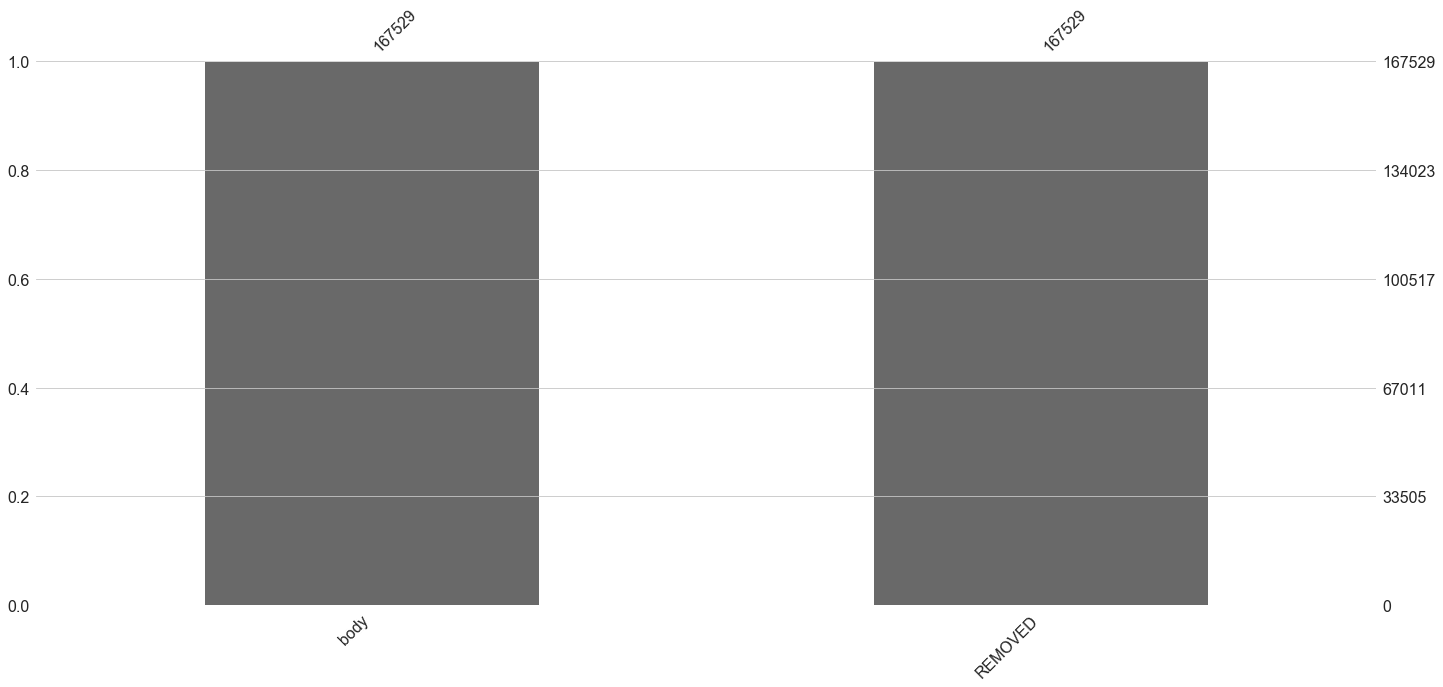

In [15]:
msno.bar(df_train)

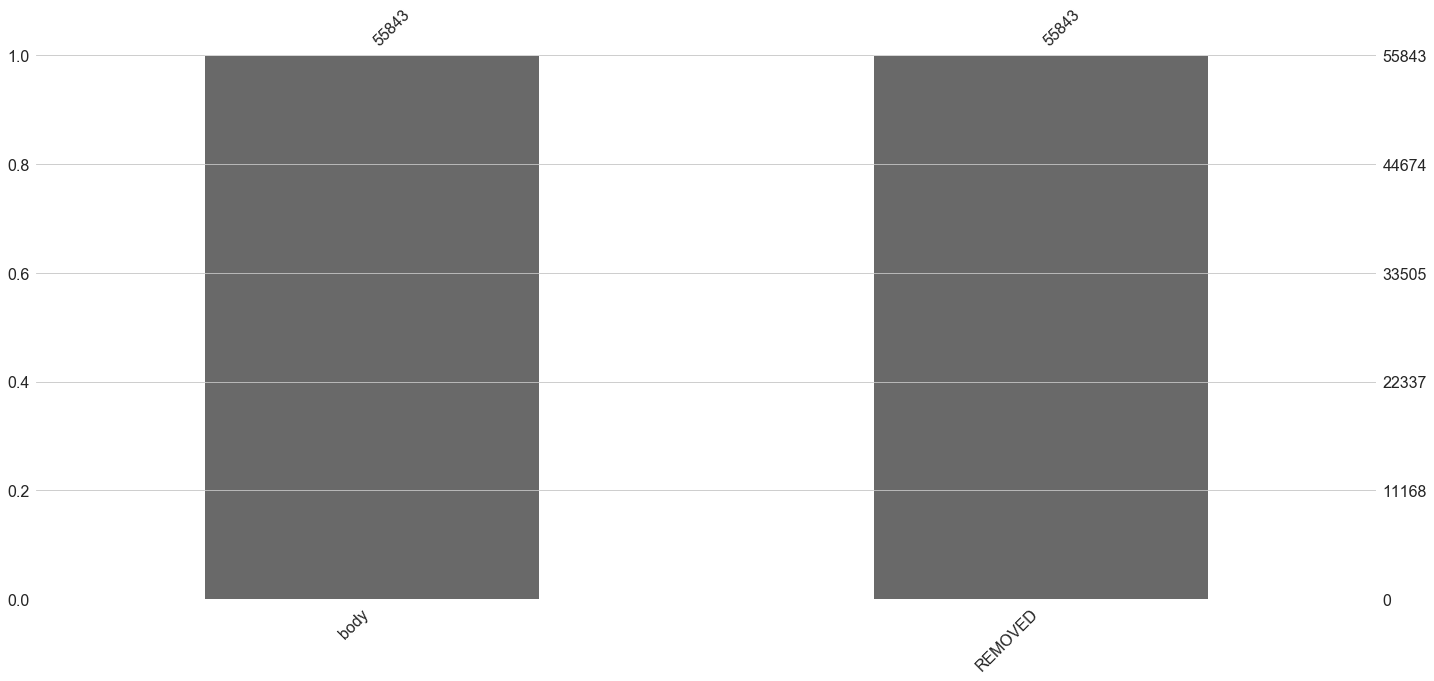

In [16]:
msno.bar(df_test)

In [17]:
print("training class balance: ", np.bincount(df_train['REMOVED']) / df_train.shape[0])
print("test class balance: ", np.bincount(df_test['REMOVED']) / df_test.shape[0])

training class balance:  [0.61357138 0.38642862]
test class balance:  [0.61896746 0.38103254]


In [18]:
print(df_train[df_train['REMOVED'] == True].shape)
print(df_train[df_train['REMOVED'] == False].shape)

(64738, 2)
(102791, 2)


The classes are somewhat imbalanced, with the positive class being the smaller class.  Therefore the Weighted F1 score should be a reasonable metric to use to account for the class imbalance.

#### Data Cleaning

From inspection I noticed html tags are escaped as character entities, so this is just some basic cleaning to unescape those character into the true html tags:

In [19]:
df_train.body = df_train.body.apply(lambda doc: html.unescape(doc))
df_test.body = df_test.body.apply(lambda doc: html.unescape(doc))

## Task 1 Bag of Words and simple Features

#### 1.1 Create a baseline model using a bag-of-words approach and a linear model

I first apply the count vectorizer directly to the documents to get a notion of the dimensionality of the transformed data.

In [20]:
X_train = df_train.drop(['REMOVED'], axis=1)
y_train = df_train['REMOVED']
X_test = df_test.drop(['REMOVED'], axis=1)
y_test = df_test['REMOVED']

In [21]:
vect = CountVectorizer()
vect2 = CountVectorizer(min_df=2)
vect4 = CountVectorizer(min_df=4)

X_transformed = vect.fit_transform(X_train.body)
X_transformed2 = vect2.fit_transform(X_train.body)
X_transformed4 = vect4.fit_transform(X_train.body)

In [22]:
print(X_transformed.shape)
print(X_transformed2.shape)
print(X_transformed4.shape)

(167529, 113804)
(167529, 50645)
(167529, 31883)


Evidently over half our words appear in only one document—since when we set `min_df=2` the dimensionality decreases my more than half compared to the default.  This `min_df` parameter will be worth tuning later on. 

Next I create a baseline model using bag-of-words to embed the text data, and a try few different linear models, but do not include any parameter tuning either in the preprocessing or in the linear models themselves.

In [23]:
class HackyWorkAround(TransformerMixin):
    """ 
    CountVectorizer was not working with ColumnTransformer 
    when passing in a DataFrame, so this filters to just the column
    we want.  It is necessary to be able to pass a DataFrame to so
    that the pipeline can support additional features that we add later
    """
    def __init__(self, col):
        self.col = col
    
    def fit(self, X, y=None):
        """fit to X"""
        return self

    def transform(self, X):
        """transform X"""
        return X[self.col]

In [24]:
preprocess = make_column_transformer(
    (make_pipeline(HackyWorkAround('body'), CountVectorizer()), ['body'])
)

pipes = {}
pipes['SGDClassifier'] = make_pipeline(preprocess, SGDClassifier())
pipes['LogisticRegression'] = make_pipeline(preprocess, LogisticRegression(solver='liblinear'))
pipes['LinearSVC'] = make_pipeline(preprocess, LinearSVC())
pipes['MultinomialNB'] = make_pipeline(preprocess, MultinomialNB())

In [25]:
mean_scores = {}

for name, pipe in pipes.items():
    print(f'Processing {name}...')
    scores = cross_val_score(pipe, X_train, y_train, cv=5, scoring='f1_weighted')
    mean_scores[name] = np.mean(scores)


Processing SGDClassifier...
Processing LogisticRegression...
Processing LinearSVC...
Processing MultinomialNB...


In [26]:
for name, val in mean_scores.items():
    print(f'{name}: {val:.4}')

SGDClassifier: 0.6762
LogisticRegression: 0.6862
LinearSVC: 0.6703
MultinomialNB: 0.6787


#### 1.2 Try using n-grams, characters, tf-idf rescaling and possibly other ways to tune the BoWmodel. Be aware that you might need to adjust the (regularization of the) linear model for different feature sets.

To start, I apply some basic tuning methods to try to improve the model.  Specifically, I try adding stop words and apply the default tf-idf rescaling. 

In [27]:
preprocess2 = make_column_transformer(
    (make_pipeline(HackyWorkAround('body'),
                   CountVectorizer(stop_words='english'), 
                   TfidfTransformer()), ['body']), 
    remainder='passthrough'
)

pipes2 = {}
pipes2['SGDClassifier'] = make_pipeline(preprocess2, SGDClassifier())
pipes2['LogisticRegression'] = make_pipeline(preprocess2, LogisticRegression(solver='liblinear'))
pipes2['LinearSVC'] = make_pipeline(preprocess2, LinearSVC())
pipes2['MultinomialNB'] = make_pipeline(preprocess2, MultinomialNB())

In [28]:
mean_scores2 = {}

for name, pipe in pipes2.items():
    print(f'Processing {name}...')
    scores = cross_val_score(pipe, X_train, y_train, cv=5, scoring='f1_weighted')
    mean_scores2[name] = np.mean(scores)


Processing SGDClassifier...
Processing LogisticRegression...
Processing LinearSVC...
Processing MultinomialNB...


In [29]:
for name, val in mean_scores2.items():
    print(f'{name}: {val:.4}')

SGDClassifier: 0.6188
LogisticRegression: 0.6903
LinearSVC: 0.6822
MultinomialNB: 0.633


It appears the SGDClassifer and MultinomialNB performed slightly worse, however the LogisticRegression and LinearSVC performed slightly better with the above parameter tuning. 

Next, I create parameter grids and perform grid search with cross validation on a larger parameter space that includes min and max document frequency values, n-grams, character analysis in addition to word analysis, and the same tf-idf rescaling and stop words as before. Note that I have limited the number of parameters because the grid search takes quite long, but this could easily be extended to a larger parameter space in a real-world/production setting.

In [30]:
transform_params = {
    'columntransformer__pipeline__countvectorizer__min_df': [1, 2],
    'columntransformer__pipeline__countvectorizer__max_df': [0.75, 1.0],
    'columntransformer__pipeline__countvectorizer__ngram_range': [(1,1), (1, 2)],
    'columntransformer__pipeline__countvectorizer__analyzer': ['word', 'char']
}


In [31]:
sgd_params = {
    **transform_params,
    'sgdclassifier__alpha': [1e-3, 1e-4, 1e-5],
}

sgd_grid = GridSearchCV(pipes2['SGDClassifier'], sgd_params, cv=5, scoring='f1_weighted', return_train_score=True, n_jobs=-1)
sgd_grid.fit(X_train, y_train)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('columntransformer', ColumnTransformer(n_jobs=None, remainder='passthrough', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('pipeline', Pipeline(memory=None,
     steps=[('hackyworkaround', <__main__.HackyWorkAround object at 0x136f6d320>), ('countvectorizer...m_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'columntransformer__pipeline__countvectorizer__min_df': [1, 2], 'columntransformer__pipeline__countvectorizer__max_df': [0.75, 1.0], 'columntransformer__pipeline__countvectorizer__ngram_range': [(1, 1), (1, 2)], 'columntransformer__pipeline__countvectorizer__analyzer': ['word', 'char'], 'sgdclassifier__alpha': [0.001, 0.0001, 1e-05]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='f1_weighte

In [32]:
print(sgd_grid.best_score_)
for param, val in sgd_grid.best_params_.items():
    print(f'{param}: {val}')

0.6905137771589092
columntransformer__pipeline__countvectorizer__analyzer: word
columntransformer__pipeline__countvectorizer__max_df: 1.0
columntransformer__pipeline__countvectorizer__min_df: 1
columntransformer__pipeline__countvectorizer__ngram_range: (1, 2)
sgdclassifier__alpha: 1e-05


In [33]:
lgr_params = {
    **transform_params,
    'logisticregression__C': np.logspace(-3, 3, 3)
}

lgr_grid = GridSearchCV(pipes2['LogisticRegression'], lgr_params, cv=5, scoring='f1_weighted', return_train_score=True, n_jobs=-1)
lgr_grid.fit(X_train, y_train)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('columntransformer', ColumnTransformer(n_jobs=None, remainder='passthrough', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('pipeline', Pipeline(memory=None,
     steps=[('hackyworkaround', <__main__.HackyWorkAround object at 0x136f6d320>), ('countvectorizer...ty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'columntransformer__pipeline__countvectorizer__min_df': [1, 2], 'columntransformer__pipeline__countvectorizer__max_df': [0.75, 1.0], 'columntransformer__pipeline__countvectorizer__ngram_range': [(1, 1), (1, 2)], 'columntransformer__pipeline__countvectorizer__analyzer': ['word', 'char'], 'logisticregression__C': array([1.e-03, 1.e+00, 1.e+03])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='

In [34]:
print(lgr_grid.best_score_)
for param, val in lgr_grid.best_params_.items():
    print(f'{param}: {val}')

0.691509030610613
columntransformer__pipeline__countvectorizer__analyzer: word
columntransformer__pipeline__countvectorizer__max_df: 0.75
columntransformer__pipeline__countvectorizer__min_df: 2
columntransformer__pipeline__countvectorizer__ngram_range: (1, 2)
logisticregression__C: 1.0


In [35]:
svm_params = {
    **transform_params,
    'linearsvc__C': np.logspace(-3, 3, 3)
}

svm_grid = GridSearchCV(pipes2['LinearSVC'], svm_params, cv=5, scoring='f1_weighted', return_train_score=True, n_jobs=-1)
svm_grid.fit(X_train, y_train)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('columntransformer', ColumnTransformer(n_jobs=None, remainder='passthrough', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('pipeline', Pipeline(memory=None,
     steps=[('hackyworkaround', <__main__.HackyWorkAround object at 0x136f6d320>), ('countvectorizer...ax_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'columntransformer__pipeline__countvectorizer__min_df': [1, 2], 'columntransformer__pipeline__countvectorizer__max_df': [0.75, 1.0], 'columntransformer__pipeline__countvectorizer__ngram_range': [(1, 1), (1, 2)], 'columntransformer__pipeline__countvectorizer__analyzer': ['word', 'char'], 'linearsvc__C': array([1.e-03, 1.e+00, 1.e+03])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='f1_weight

In [36]:
print(svm_grid.best_score_)
for param, val in svm_grid.best_params_.items():
    print(f'{param}: {val}')

0.6902278425529204
columntransformer__pipeline__countvectorizer__analyzer: word
columntransformer__pipeline__countvectorizer__max_df: 0.75
columntransformer__pipeline__countvectorizer__min_df: 1
columntransformer__pipeline__countvectorizer__ngram_range: (1, 2)
linearsvc__C: 1.0


In [37]:
mnb_params = {
    **transform_params,
    'multinomialnb__alpha': [1e-3, 1e-4, 1e-5],
}

mnb_grid = GridSearchCV(pipes2['MultinomialNB'], mnb_params, cv=5, scoring='f1_weighted', return_train_score=True, n_jobs=-1)
mnb_grid.fit(X_train, y_train)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('columntransformer', ColumnTransformer(n_jobs=None, remainder='passthrough', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('pipeline', Pipeline(memory=None,
     steps=[('hackyworkaround', <__main__.HackyWorkAround object at 0x136f6d320>), ('countvectorizer...ue))]), ['body'])])), ('multinomialnb', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'columntransformer__pipeline__countvectorizer__min_df': [1, 2], 'columntransformer__pipeline__countvectorizer__max_df': [0.75, 1.0], 'columntransformer__pipeline__countvectorizer__ngram_range': [(1, 1), (1, 2)], 'columntransformer__pipeline__countvectorizer__analyzer': ['word', 'char'], 'multinomialnb__alpha': [0.001, 0.0001, 1e-05]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='f1_weighte

In [38]:
print(mnb_grid.best_score_)
for param, val in mnb_grid.best_params_.items():
    print(f'{param}: {val}')

0.6830106347440476
columntransformer__pipeline__countvectorizer__analyzer: word
columntransformer__pipeline__countvectorizer__max_df: 0.75
columntransformer__pipeline__countvectorizer__min_df: 2
columntransformer__pipeline__countvectorizer__ngram_range: (1, 1)
multinomialnb__alpha: 0.001


#### 1.3 Explore other features you can derive from the text, such as html, length, punctuation, capitalization or other features you deem important from exploring the dataset

I start by generating a feature for document length, as well as count features for html/emoji, punctuation, capitalization, urls, and bad words. Since the count of html/emojis, punctuation, capitalization and urls is likely, at least in part, a function of the document length, I thought the ratio of each of these over document length might provide stronger signals as well.

I then lemmatize the documents (before the pipeline so we only have to do it once) and cache this file since the operation takes a long time. 

In [39]:
# Load helper dataset retrieved from: https://www.kaggle.com/nicapotato/bad-bad-words
bad_word_list = pd.read_csv('./data/bad-words.csv', sep='\n', header=None).values.flatten().tolist()
bad_words = set(word.strip() for word in bad_word_list)

In [40]:
def derive_features(df):
    """ derive new features for given df """

    df['doc_length'] = df.body.apply(lambda doc: len(doc))

    # counts html tags - note this also includes many unicode emojis wrapped in < > tags
    df['html_count'] = df.body.apply(lambda doc: len(re.findall(r'<[^>]+>', doc)))

    # counts punctuation, excludes alphanumerics and spaces
    df['punctuation_count'] = df.body.apply(lambda doc: len(re.findall(r'[^a-zA-Z0-9\s]', doc)))

    # counts capitalized letters matches
    df['caps_count'] = df.body.apply(lambda doc: len(re.findall(r'[A-Z]+', doc)))

    # counts urls matches     
    df['url_count'] = df.body.apply(lambda doc: len(re.findall(r'(?P<url>https?://[^\s]+)', doc)))

    # counts bad word matches     
    df['bad_word_count'] = df.body.apply(lambda doc: len([w for w in doc.split() if w in bad_words]))
        
    # counts the word "removed" — at the top, I noticed many documents discussing being removed
    df['removed_count'] = df.body.apply(lambda doc: len(re.findall(r'\bremoved\b', doc)))
    
    # derives ratios of each count feature above relative to doc_length     
    df['html_ratio'] = df.apply(lambda x: x.html_count/x.doc_length, axis=1)
    df['punctuation_ratio'] = df.apply(lambda x: x.punctuation_count/x.doc_length, axis=1)
    df['caps_ratio'] = df.apply(lambda x: x.caps_count/x.doc_length, axis=1)
    df['url_ratio'] = df.apply(lambda x: x.url_count/x.doc_length, axis=1)
    df['bad_word_ratio'] = df.apply(lambda x: x.bad_word_count/x.doc_length, axis=1)
    df['removed_ratio'] = df.apply(lambda x: x.removed_count/x.doc_length, axis=1)
    
    return df

In [41]:
# Reference: https://www.machinelearningplus.com/nlp/lemmatization-examples-python/
def lemmatize(doc):
    """ Lemmatize the given doc """
    def get_wordnet_pos(word):
        """ Map POS tag to first character lemmatize() accepts """
        tag = pos_tag([word])[0][1][0].upper()
        tag_dict = {'J': wordnet.ADJ,
                    'N': wordnet.NOUN,
                    'V': wordnet.VERB,
                    'R': wordnet.ADV}

        return tag_dict.get(tag, wordnet.NOUN)

    lemmatizer = WordNetLemmatizer()
    return ' '.join([lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in word_tokenize(doc)])

In [42]:
# derive new features
df_train = derive_features(df_train)
df_test = derive_features(df_train)

In [43]:
# lemmatize df_train and df_test (this takes longs so we save to cache or load from cache if available)
try:
    df_train = load_from_cache('./cache/train_lemma.pkl', 'train_lemma')
except FileNotFoundError as e:
    df_train.body = df_train.body.apply(lambda doc: lemmatize(doc))
    save_to_cache('./cache/train_lemma.pkl', 'train_lemma', df_train)

try:
    df_test = load_from_cache('./cache/test_lemma.pkl', 'test_lemma')
except FileNotFoundError as e:
    df_test.body = df_test.body.apply(lambda doc: lemmatize(doc))
    save_to_cache('./cache/test_lemma.pkl', 'test_lemma', df_test)

Loading train_lemma data from cache...
Took 0.36 seconds to load train_lemma data
Loading test_lemma data from cache...
Took 0.14 seconds to load test_lemma data


Update our X and y datasets with the new features. Let's see how well the models perform if we only use our derived features...

In [44]:
X_train = df_train.drop(['REMOVED'], axis=1)
y_train = df_train['REMOVED']
X_test = df_test.drop(['REMOVED'], axis=1)
y_test = df_test['REMOVED']

In [45]:
X_train_derived_only = X_train.drop(['body'], axis=1)

In [46]:
np.mean(cross_val_score(SGDClassifier(alpha=1e-5), X_train_derived_only, y_train, cv=5, scoring='f1_weighted'))

0.5862370636518358

In [47]:
np.mean(cross_val_score(LogisticRegression(solver='liblinear', C=1), X_train_derived_only, y_train, cv=5, scoring='f1_weighted'))

0.548869981153288

In [48]:
np.mean(cross_val_score(LinearSVC(C=1), X_train_derived_only, y_train, cv=5, scoring='f1_weighted'))

0.4306740685294626

In [49]:
np.mean(cross_val_score(MultinomialNB(alpha=1e-5), X_train_derived_only, y_train, cv=5, scoring='f1_weighted'))

0.5610561733120385

Now let's see how well the model does overall. Note that I use the best parameters found in the gridsearch for respective `alpha` and `C` values.

In [50]:
preprocess3 = make_column_transformer(
    (make_pipeline(HackyWorkAround('body'),
                   CountVectorizer(
                       stop_words='english',
                       max_df=0.75,
                       ngram_range=(1,2)), 
                   TfidfTransformer()), ['body']), 
    remainder='passthrough'
)

pipes3 = {}
pipes3['SGDClassifier'] = make_pipeline(preprocess3, SGDClassifier(alpha=1e-5))
pipes3['LogisticRegression'] = make_pipeline(preprocess3, LogisticRegression(solver='liblinear', C=1))
pipes3['LinearSVC'] = make_pipeline(preprocess3, LinearSVC(C=1))
pipes3['MultinomialNB'] = make_pipeline(preprocess3, MultinomialNB(alpha=0.001))

In [51]:
mean_scores3 = {}

for name, pipe in pipes3.items():
    print(f'Processing {name}...')
    scores = cross_val_score(pipe, X_train, y_train, cv=5, scoring='f1_weighted')
    mean_scores3[name] = np.mean(scores)


Processing SGDClassifier...
Processing LogisticRegression...
Processing LinearSVC...
Processing MultinomialNB...


In [52]:
for name, val in mean_scores3.items():
    print(f'{name}: {val:.4}')

SGDClassifier: 0.4801
LogisticRegression: 0.6958
LinearSVC: 0.4881
MultinomialNB: 0.4733


Notice that with lemmatized body text, and including our new derived features, the SGDClassifier and MultinomialNB both actually perform much worse than when we only used the derived features. The LinearSVC also performs much worse than our model from part 2 in which it achieved almost .7 weighted F1-score through grid search.  The LogisticRegression remains the best performing model, improving slightly to just under .7 weighted F1-score. 

Before moving on, I decided to run these same models once more, but instead using AUC ROC as the metric.  The goal of this is to give me a reference point to compare my models with the Kaggle kernels (where we originally sourced the dataset from) since most of the kernels report the AUC ROC score. The best scores for that Kaggle competition are apparenty just above .8 AUC ROC (anywhere ~0.8-0.82 appear to be top ranked on the leaderboard).

In [53]:
mean_scores3roc_auc = {}

for name, pipe in pipes3.items():
    print(f'Processing {name}...')
    scores = cross_val_score(pipe, X_train, y_train, cv=5, scoring='roc_auc')
    mean_scores3roc_auc[name] = np.mean(scores)


Processing SGDClassifier...
Processing LogisticRegression...
Processing LinearSVC...
Processing MultinomialNB...


In [54]:
for name, val in mean_scores3roc_auc.items():
    print(f'{name}: {val:.4}')

SGDClassifier: 0.6631
LogisticRegression: 0.7714
LinearSVC: 0.6854
MultinomialNB: 0.6741


While the SGDClassifier, LinearSVC and MultinomialNB all perform under 0.7, the Logistic regression achieved nearly 0.78 which seems reasonable compared to the Kaggle leaderboard, especially given a simpler model.  

Let's finish by evaluating how these models generalize to the test set, so that we can later compare this to the Task 2 Word Vector model.

In [55]:
for name, pipe in pipes3.items():
    print(f'Generalization score for {name}...')
    pipe.fit(X_train, y_train)
    print(f'{pipe.score(X_test, y_test):.4}')

Generalization score for SGDClassifier...
0.6339
Generalization score for LogisticRegression...
0.687
Generalization score for LinearSVC...
0.6945
Generalization score for MultinomialNB...
0.6221


## Task 2 Word Vectors

Now I use the Google News pretrained word-embedding instead of the bag-of-words model.

In [56]:
# Load Google's pre-trained Word2Vec model.
google_w2v = models.KeyedVectors.load_word2vec_format('./models/GoogleNews-vectors-negative300.bin', binary=True)

The model uses only the word2vec vectors as training data, excluding our other derived features. I created a class that extends scikit-learn's transform interface so that we can run the word2vec transform from within a scikit-learn pipeline. However I still just run the word2vec transformation outside the pipeline since it takes a bit of time, this way it doesn't repeat for each model... 

In [57]:
class Word2VecTransform(TransformerMixin):
    """ 
    Given X and model, generates word vectors for X.
    
    'model' should be a pretrained gensim model
    'X' should be an numpy ndarray
    
    Reference:
    https://github.com/amueller/COMS4995-s19/blob/master/slides/aml-19-word-embeddings/aml-21-word-embeddings.ipynb
    """
    def __init__(self, model):
        self.model = model
        self.vect = CountVectorizer(vocabulary=model.index2word)
    
    def fit(self, X, y=None):
        """ fit to X """
        return self.vect.fit(X)

    def transform(self, X):
        """ transform X """
            
        docs = self.vect.inverse_transform(self.vect.transform(X))
            
        # Note: if the doc is and empty array then we generate a dummy result of shape (300,) 
        # to replace it in our dataset. This is a minority of cases, but basically this will 
        # occur if our doc did not contain any words in the Google News vocabulary and therefor
        # results in zero word tokens in our doc array        
        return np.vstack([
            np.mean(self.model[doc], axis=0) if (doc.shape[0] > 0) else np.zeros(300) for doc in docs])

In [58]:
w2v = Word2VecTransform(google_w2v)

# TODO: fit_transform doesn't output correct dimensions, but fit and transform run separately works correctly
w2v.fit(X_train.body)
X_train_w2v = w2v.transform(X_train.body)

X_test_w2v = w2v.transform(X_test.body)

In [59]:
X_train_w2v.shape

(167529, 300)

In [60]:
X_test_w2v.shape

(55843, 300)

The commented out code shows how this would look if run in a Pipeline.  However, I may still have a bug in the fit_transform function (see code comment above), which would have to be worked out before running it like this. I just kept this for clarify to parallel the structure I've used throughout the assignment.

In [61]:
# preprocess4 = make_column_transformer(
#     (make_pipeline(HackyWorkAround('body'), Word2VecTransform(google_w2v)), ['body'])
# )

pipes4 = {}
pipes4['SGDClassifier'] = SGDClassifier(alpha=1e-5) # make_pipeline(preprocess4, SGDClassifier(alpha=1e-5))
pipes4['LogisticRegression'] = LogisticRegression(solver='liblinear', C=1) # make_pipeline(preprocess4, LogisticRegression(solver='liblinear', C=1))
pipes4['LinearSVC'] = LinearSVC(C=1) # make_pipeline(preprocess4, LinearSVC(C=1))

# MultinomialNB can't have negative input values, but our word vectors contain negatives so I exclude this here
# pipes4['MultinomialNB'] = MultinomialNB() # make_pipeline(preprocess4, MultinomialNB())


In [62]:
mean_scores4 = {}

for name, pipe in pipes4.items():
    print(f'Processing {name}...')
    scores = cross_val_score(pipe, X_train_w2v, y_train, cv=5, scoring='f1_weighted')
    mean_scores4[name] = np.mean(scores)


Processing SGDClassifier...
Processing LogisticRegression...
Processing LinearSVC...


In [63]:
for name, val in mean_scores4.items():
    print(f'{name}: {val:.4}')

SGDClassifier: 0.5983
LogisticRegression: 0.66
LinearSVC: 0.6569


All of the Word2Vec models appears to perform a bit worse than their corresponding models from Task 1 (referring to the best scores found with Gridsearch), they however perform better than the models that include lemmatization and additional features. 

Again for reference, like in Task 1 I will run the Word2Vec models once more using the AUC ROC metric, as well as see how they models generalize to the test set.

In [64]:
mean_scores4roc_auc = {}

for name, pipe in pipes4.items():
    print(f'Processing {name}...')
    scores = cross_val_score(pipe, X_train_w2v, y_train, cv=5, scoring='roc_auc')
    mean_scores4roc_auc[name] = np.mean(scores)


Processing SGDClassifier...
Processing LogisticRegression...
Processing LinearSVC...


In [65]:
for name, val in mean_scores4roc_auc.items():
    print(f'{name}: {val:.4}')

SGDClassifier: 0.7191
LogisticRegression: 0.7279
LinearSVC: 0.7282


It appears that although the LogisticRegression did not receive as high of a score for AUC ROC in this task (~0.72 compared to ~0.77), the other two models, SGDClassifier and LinearSVC, output a higher AUC ROC score, both achieving above 0.7 whereas before they were both well below.

In [66]:
for name, pipe in pipes4.items():
    print(f'Generalization score for {name}...')
    pipe.fit(X_train_w2v, y_train)
    print(f'{pipe.score(X_test_w2v, y_test):.4}')

Generalization score for SGDClassifier...
0.6741
Generalization score for LogisticRegression...
0.6797
Generalization score for LinearSVC...
0.6797


In terms of generalization, the SGDClassifier performs better than the model from Task 1, however the LogisticRegression and LinearSVC both perform a bit worse.  One thing I did not do in Task 1 was evaluate how well the grid search models generalize. And so I will finish with that:

In [67]:
sgd_grid.score(X_test, y_test)

0.6917786633671364

In [68]:
lgr_grid.score(X_test, y_test)

0.6906119038595159

In [69]:
svm_grid.score(X_test, y_test)

0.6860237913253923

In [70]:
mnb_grid.score(X_test, y_test)

0.6802934609298993

All of these models appear to generalize slightly better than the models from Task 2. Compared to the models from Task 1 that included lemmatization and derived features, the SGDClassifier and MultinomialNB both generalize much better, however the LogisticRegression is only slightly better and LinearSVC is slightly worse.  But none of them exceed the absolute best generalization score of 0.6945 achieved by the LinearSVC.  This is interesting and somewhat unexpected given that, for most of the experiments, it was actually the LogisticRegression, not the LinearSVC, that provided the best validation scores.